## **14. Deep Q-Network (DQN)**

In this practice session, we will cover the following:
- Deep Q-Network

&nbsp;

**[Important]** The results of exercises should be included in your weekly report for this practice session. The weekly report for this session should be submitted on KLMS by this friday. No late submission would be accepted.

## 0. Preview

![demo](https://www.gymlibrary.dev/_images/cart_pole.gif)

**Cartpole** is a problem of maintaining balance by pushing the cart to the left or right. When DQN (and other RL algorithms) is applied to this game, it autonomously learns by repeatedly remembering and replaying experiences, gradually developing strategies.

&nbsp;

As learned in the lecture, in order to apply RL algorithms, the environment must be clearly defined in terms of states, actions, and rewards.

### Let's analyze the state, action, and reward of Cartpole.

&nbsp;

**Checking the overall environment setup**

![](https://drive.google.com/uc?export=view&id=1mp0pl6R6kuR0W38zsSmEDR4PwmVRiqiK)

&nbsp;

**State space**: Current position, angle of the pole, velocity, angle velocity of the pole (four numbers in four dimensions).

![](https://drive.google.com/uc?export=view&id=1ofqlrfpEAXRQ9klns_gHjuzWrGfrBMQC)


&nbsp;

**Action space**: Push to the right or left.

![](https://drive.google.com/uc?export=view&id=1APePl4WaoP4qdH5hO1zt3-79JiB-i7RX)

&nbsp;

**Reward function**: Receives a reward of +1 at each time step.
If the pole tilts more than 2.4 units from the center, the episode terminates.

Next, let's define the CartPole environment using the gym library. We can confirm that the state space and action space match what we analyzed earlier.

In [1]:
# import required libraries
import gym
import numpy as np
import collections
import random
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!pip install gym==0.25.2

In [3]:
env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("state space dimension: {}".format(state_dim))
print("action space dimension: {}".format(action_dim))

state space dimension: 4
action space dimension: 2


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Checking Built-in Methods in the **env**.

- The **env.reset()** function returns initial state information.
- The **env.step(action)** function returns information about the \<next state, reward, done (whether the episode is done or not), truncated (do not use)\> information obtained after taking an action

In [4]:
print(env.reset())

action = env.action_space.sample()
print(env.step(action))

[ 0.00778503  0.01444008  0.0155442  -0.02553568]
(array([ 0.00807383,  0.20933571,  0.01503349, -0.313274  ], dtype=float32), 1.0, False, {})


Before diving into the application of RL algorithms, let's visually witness how Cartpole reacts to actions in the rendering environment.

To make this observation possible, a few library installations are necessary.

In [5]:
# Install xvfb & other dependencies
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
# python-opengl > /dev/null 2>&1
!apt-get install xvfb
# As well as pyvirtual display
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxfont2 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
The following NEW packages will be installed:
  libxfont2 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 7 newly installed, 0 to remove and 15 not upgraded.
Need to get 7,727 kB of archives.
After this operation, 11.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 xfonts-encodings all 1:1.0.5-0ubuntu2 [578 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 xfonts-utils amd64 1:7.7+6build2 [94.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/main amd64 xfonts-base a

In [6]:
# then import all your libraries, including matplotlib & ipythondisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [7]:
Display(visible=0, size=(400, 300)).start()

In [8]:
# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Now, let's observe the changes in the CartPole environment after performing random actions for 100 time steps.

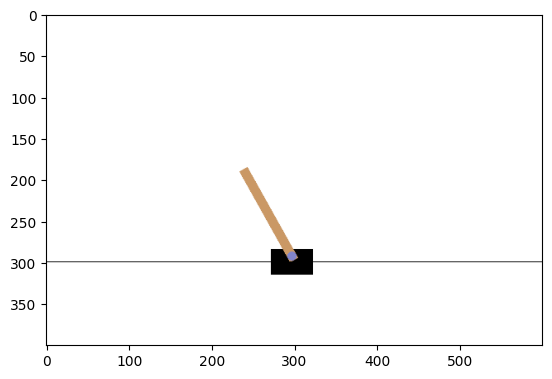

In [10]:
from IPython import display

env = gym.make("CartPole-v0")
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for i in range(100):
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

## 1. Implementing the Deep Q-Network (DQN)


Let's implement the DQN algorithm!

&nbsp;

The DQN algorithm can be visualized with the diagram below. We can observe that it consists of two networks: **the Policy network and the Target network**. The Policy network is the network we aim to train, while the Target network has the same structure as the Policy network and serves to enhance training stability.

&nbsp;

During the training process, actions sampled from the Policy network result in the dynamics of the environment being stored in a place called the replay memory. Subsequently, at specific intervals, the samples stored in the memory are used to optimize the network, and the parameters of the target network are updated with the parameters of the current policy network periodically.

&nbsp;


Each structure will be explained in the order of the numbers in the diagram.

<img src="https://drive.google.com/uc?export=view&id=1skkb6PgU5mDn5_PGmxmhH6JhaYTFQLSW" width="920" height="500" />


### 1.1. Define a replay buffer (memory)

Replay buffer is the storage of observed agent transitions, available for subsequent training reuse. Random sampling from this buffer mixes transitions to mitigate correlation, ultimately enhancing DQN training stability and performance. This technique significantly improves the training process of DQNs.

&nbsp;

The ReplayBuffer class is defined by the following methods.

&nbsp;

**ReplayBuffer()**
- put(): A method for inserting
  - buffer_limit: Maximum size of the buffer
  - Its role involves placing transitions into the buffer as they arrive.
- sample(): A method for extracting
  - It involves selecting 32 items and converting them into a tensor.
  - It randomly picks 32 items from the buffer to create a mini_batch_.
- size(): Indicates the number of items currently in the buffer.

In [11]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

### 1.2. Define a Q-Network

The Q-network refers to a neural network that approximates the Q-values of different actions in a given state. Q-values represent the expected cumulative reward that an agent can achieve by taking a specific action in a particular state and then following the optimal policy thereafter.

The Q-network takes the current state as input and outputs a vector of Q-values, where each value corresponds to a different action that the agent can take. The highest Q-value indicates the action that the agent believes will yield the maximum expected reward.


&nbsp;

<img src="https://drive.google.com/uc?export=view&id=1sSgJQxb5X4hEbdi3yT4IYGu9vnSbcBLV" width="570" height="450" />

&nbsp;

The QNet class is defined by the following methods.

&nbsp;

- sample_action(): with a probability of epsilon, take a random action, and in the remaining cases, take the greedy action (the action with the highest q-value).



In [12]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()

### 1.3. Updating the model using samples stored in the buffer.


<img src="https://drive.google.com/uc?export=view&id=1PiVEfCUbQy9AInJfxfLyOMjDoGw2xVBo" width="600" height="130" />


In [13]:
# Hyperparameters

learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

#### **Exercise**. Referencing the Loss function in the diagram, implement the loss that will be used to update the model.
Obtain the predicted Q-values through the policy network (green part in the diagram), then compute the target Q-values using the target network (blue part in the diagram). By calculating the difference between these two Q-values, you can define the loss.

In [18]:
def update_model(q, q_target, memory, optimizer, criterion):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        """ ### Implement the code yourself ### """
        # get predicted q value (using policy network)
        q_val = q(s)
        q_a = q_val.gather(1, a)

        # get target q value (using target network)
        q_target_val = q_target(s_prime)
        max_q = q_target_val.max(dim=1)[0].unsqueeze(1)

        # Update the target value only if the episode ends.
        target = r + gamma * max_q * done_mask


        # define loss
        loss = criterion(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### 1-4. Train the DQN

In [23]:
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = 0.0

optimizer = optim.Adam(q.parameters(), lr=learning_rate)
criterion = F.smooth_l1_loss

for n_epi in range(1000):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
    s = env.reset()
    done = False

    while not done:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, truncated = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        if done:
            break

    if memory.size() > 2000:
        update_model(q, q_target, memory, optimizer, criterion)

    if n_epi%print_interval==0 and n_epi!=0:
        q_target.load_state_dict(q.state_dict())
        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                        n_epi, score/print_interval, memory.size(), epsilon*100))
        score = 0.0
env.close()

n_episode :20, score : 10.2, n_buffer : 204, eps : 7.9%
n_episode :40, score : 9.9, n_buffer : 403, eps : 7.8%
n_episode :60, score : 9.8, n_buffer : 599, eps : 7.7%
n_episode :80, score : 10.2, n_buffer : 803, eps : 7.6%
n_episode :100, score : 9.7, n_buffer : 997, eps : 7.5%
n_episode :120, score : 10.2, n_buffer : 1202, eps : 7.4%
n_episode :140, score : 10.1, n_buffer : 1404, eps : 7.3%
n_episode :160, score : 9.3, n_buffer : 1590, eps : 7.2%
n_episode :180, score : 9.8, n_buffer : 1785, eps : 7.1%
n_episode :200, score : 9.4, n_buffer : 1974, eps : 7.0%
n_episode :220, score : 15.2, n_buffer : 2277, eps : 6.9%
n_episode :240, score : 12.7, n_buffer : 2530, eps : 6.8%
n_episode :260, score : 17.2, n_buffer : 2875, eps : 6.7%
n_episode :280, score : 25.6, n_buffer : 3386, eps : 6.6%
n_episode :300, score : 94.3, n_buffer : 5273, eps : 6.5%
n_episode :320, score : 64.7, n_buffer : 6567, eps : 6.4%
n_episode :340, score : 160.8, n_buffer : 9782, eps : 6.3%
n_episode :360, score : 165.

### Now, let's use our trained DQN model to observe how CartPole moves. You'll notice a distinct difference compared to the initial behavior.

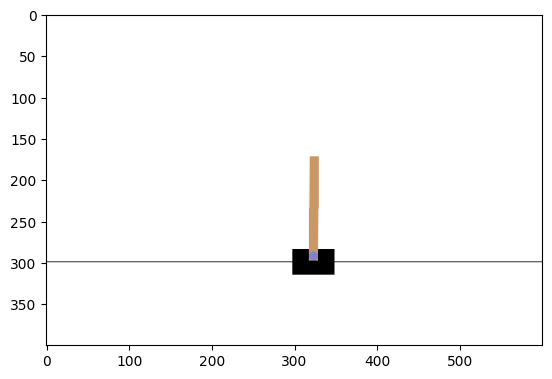

In [25]:
env = gym.make('CartPole-v0')
s = env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for i in range(100):
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = q.sample_action(torch.from_numpy(s).float(), 0)
    s, _, _, _ = env.step(action)

## References
  - https://github.com/seungeunrho/minimalRL
  - https://github.com/rlcode/per
  - https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
  - https://www.gymlibrary.dev/environments/classic_control/cart_pole/